In [1]:
import pypsa 
import pandas as pd
import numpy as np

## Einlesen der Datenreihen

In [2]:
#infeed renewables
data_pv = pd.read_csv('data/data_pv_antofagasta_1MW.csv', skiprows = 3)['electricity']/1000
data_wind = pd.read_csv('data/data_wind_antofagasta_1MW.csv', skiprows = 3)['electricity']/1000
data_electrolysis = pd.read_excel('data/load_electrolysis.xlsx')['hydrogen']
data_shipping_1 = pd.read_excel('data/Ferntransport.xlsx')['Kapazität [MWh]']
data_shipping_2 = 0

In [3]:
#Erstellung Lastprofil
hydrogen_demand = (35 * 1000) * 33 * 1000 # MWh
hydrogen_demand_hourly = hydrogen_demand/8760 #MW

#Erstellung Elektrolyseprofil


Multilink aufbauen

override_component_attrs = pypsa.descriptors.Dict(
    {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
)
override_component_attrs["Link"].loc["bus2"] = [
    "string",
    np.nan,
    np.nan,
    "2nd bus",
    "Input (optional)",
]
override_component_attrs["Link"].loc["efficiency2"] = [
    "static or series",
    "per unit",
    1.0,
    "2nd bus efficiency",
    "Input (optional)",
]
override_component_attrs["Link"].loc["p2"] = [
    "series",
    "MW",
    0.0,
    "2nd bus output",
    "Output",
]

## Definition der Variablen

#### Leistungen

In [4]:
p_nom_pv = data_pv.max()
p_nom_wind = data_wind.max()

#### Investitionskosten

In [5]:
# generators
capital_cost_pv = 800 # €/MW
capital_cost_wind = 800 # €/MW

# links
capital_cost_PEMEL = 2500 # €/MW
capital_cost_AEL = 1200 # €/MW
capital_cost_HTEL = 1300 # €/MW
capital_cost_NH3 = 1400 # €/MW
capital_cost_LH2 = 1500 # €/MW
capital_cost_LHOC = 1600 # €/MW
capital_cost_pipeline = 5000 # €/MW
capital_cost_shipping_1 = 10000 # €/MW
capital_cost_shipping_2 = 80000 # €/MW

# storages
capital_cost_storage_GH2 = 200 # €/MW
capital_cost_storage_NH3 = 20 # €/MW
capital_cost_storage_LH2 = 20 # €/MW
capital_cost_storage_LHOC = 20 # €/MW

#### Gestehungskosten

In [6]:
# generators
marginal_cost_pv = 70 # €/MWh
marginal_cost_wind = 70 # €/MWh

# conversion
marginal_cost_PEMEL = 1000 # €/MWh
marginal_cost_AEL = 100 # €/MWh
marginal_cost_HTEL = 100 # €/MWh
marginal_cost_NH3 = 100 # €/MWh
marginal_cost_LH2 = 100 # €/MWh
marginal_cost_LHOC = 100 # €/MWh

# storage
marginal_cost_storage_GH2 = 20 # €/MWh
marginal_cost_storage_NH3 = 20 # €/MWh
marginal_cost_storage_LH2 = 20 # €/MWh
marginal_cost_storage_LHOC = 20 # €/MWh

# transportation
marginal_cost_pipeline = 200 # €/MWh
marginal_cost_shipping_GH2 = 10 # €/MWh
marginal_cost_shipping_NH3 = 10 # €/MWh
marginal_cost_shipping_LH2 = 10 # €/MWh
marginal_cost_shipping_LHOC = 10 # €/MWh

#### Sonstiges

In [7]:
# efficiencies
efficiency_PEMEL = 0.65
efficiency_AEL = 1
efficiency_HTEL = 1
efficiency_NH3 = 1
efficiency_LH2 = 1
efficiency_LHOC = 1

# lifetimes
lifetime_PEMEL = 20
lifetime_AEL = 20
lifetime_HTEL = 20

# standing losses
standing_loss_GH2 = 0.05
standing_loss_NH3 = 0.05
standing_loss_LH2 = 0.05
standing_loss_LHOC = 0.05

## Netzwerk aufbauen

In [8]:
network = pypsa.Network()
network.set_snapshots(range(8760))

#### Buses

In [9]:
network.add('Bus', name = 'electricity')
network.add('Bus', name = 'GH2')
#network.add('Bus', name = 'NH3')
#network.add('Bus', name = 'LH2')
#network.add('Bus', name = 'LHOC')
#network.add('Bus', name = 'hydrogen')

network.add('Bus', name = 'bremerhaven')
#network.add('Bus', name = 'cologne')

#### Loads

In [10]:
network.add('Load', name = 'hydrogen_demand', bus = 'bremerhaven', p_set = hydrogen_demand_hourly)

#### Generators

In [11]:
network.add('Generator', name = 'pv', bus = 'electricity', 
            p_max_pu = data_pv, p_nom_extendable = True,
            marginal_cost = marginal_cost_pv, capital_cost = capital_cost_pv)

#network.add('Generator', name = 'pv', bus = 'electricity', 
#            p_nom = p_nom_pv, p_max_pu = data_pv/p_nom_pv, p_nom_extendable = True,
#            marginal_cost = marginal_cost_pv, capital_cost = capital_cost_pv)

network.add('Generator', name = 'wind', bus = 'electricity',
            p_nom = p_nom_wind, p_max_pu = data_wind/p_nom_wind, p_nom_extendable = True,
            marginal_cost = marginal_cost_wind, capital_cost = capital_cost_wind)

#### Links - Electrolysis

In [12]:
network.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'bremerhaven', 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_PEMEL, capital_cost = capital_cost_PEMEL,
            efficiency = efficiency_PEMEL)

#network.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2',
#            p_nom = data_electrolysis.max(), p_max_pu = data_electrolysis/data_electrolysis.max(), 
#            p_nom_extendable = True,
#            marginal_cost = marginal_cost_PEMEL, capital_cost = capital_cost_PEMEL,
#            efficiency = efficiency_PEMEL)

#network.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2',
#           p_min_pu = 0.8, p_max_pu = 1, p_nom_extendable = True,
#           marginal_cost = marginal_cost_PEMEL, capital_cost = capital_cost_PEMEL,
#           efficiency = efficiency_PEMEL)

network.add('Link', name = 'AEL', bus0 = 'electricity', bus1 = 'GH2',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_AEL, capital_cost = capital_cost_AEL,
           efficiency = efficiency_AEL)
network.add('Link', name = 'HTEL', bus0 = 'electricity', bus1 = 'GH2',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_HTEL, capital_cost = capital_cost_HTEL,
           efficiency = efficiency_HTEL)

#### Links - Conversion

network.add('Link', name = 'NH3', bus0 = 'electricity', bus1 = 'NH3',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_NH3, capital_cost = capital_cost_NH3,
           efficiency = efficiency_NH3)

network.add('Link', name = 'LH2', bus0 = 'electricity', bus1 = 'LH2',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_LH2, capital_cost = capital_cost_LH2,
           efficiency = efficiency_LH2)

network.add('Link', name = 'LHOC', bus0 = 'electricity', bus1 = 'LHOC',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_LHOC, capital_cost = capital_cost_LHOC,
           efficiency = efficiency_LHOC)

#### Links - Transportation

In [13]:
# long distance shipment
network.add('Link', name = 'Ferntransport_GH2', bus0 = 'GH2', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(), p_nom_extendable = True,
            marginal_cost = marginal_cost_shipping_GH2, capital_cost = capital_cost_shipping_1)

network.add('Link', name = 'Ferntransport_NH3', bus0 = 'NH3', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(),
            marginal_cost = marginal_cost_shipping_NH3)

network.add('Link', name = 'Ferntransport_LH2', bus0 = 'LH2', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(),
            marginal_cost = marginal_cost_shipping_LH2)

network.add('Link', name = 'Ferntransport_LHOC', bus0 = 'LHOC', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(),
            marginal_cost = marginal_cost_shipping_LHOC)

# inland shipment
#TODO: Profil hinterlegen und Links einbauen

#### Storages

In [14]:
network.add('Store', name = 'antofagasta_GH2', bus = 'GH2', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_GH2)

network.add('Store', name = 'hydrogen_store_1.1', bus = 'NH3', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_NH3)

network.add('Store', name = 'hydrogen_store_1.2', bus = 'LH2', 
            e_nom_extendable = True, e_cyclic = True,  
            capital_cost = capital_cost_storage_LH2)

network.add('Store', name = 'hydrogen_store_1.3', bus = 'LHOC', 
            e_nom_extendable = True, e_cyclic = True,  
            capital_cost = capital_cost_storage_LHOC)

network.add('Store', name = 'bremerhaven_GH2', bus = 'bremerhaven', 
            e_nom_extendable = True, e_cyclic = True, 
            capital_cost = capital_cost_storage_GH2)

network.add('Store', name = 'cologne_GH2', bus = 'cologne', 
            e_nom_extendable = True, e_cyclic = True, 
            capital_cost = capital_cost_storage_GH2)

## Optimierung des Systems

In [15]:
network.lopf(pyomo = False, solver_name = 'gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.15s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-01
Read LP format model from file /var/folders/np/fxyv4bts2s353fj5gdlrbgym0000gn/T/pypsa-problem-ymc8h_ky.lp
Reading time = 0.56 seconds
obj: 254040 rows, 140170 columns, 473455 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 254040 rows, 140170 columns and 473455 nonzeros
Model fingerprint: 0x1e2ec340
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [1e+00, 1e+04]
  Bounds range     [2e+10, 2e+10]
  RHS range        [2e-05, 1e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 218268 rows and 117895 columns
Presolve time: 0.44s
Presolved: 35772 rows, 22275 columns, 93756 nonzer

INFO:pypsa.linopf:Optimization successful. Objective value: 1.89e+12


('ok', 'optimal')

## Auswertung der Ergebnisse

In [16]:
network.generators.p_nom_opt

Generator
pv      8.556920e-01
wind    5.511977e+06
Name: p_nom_opt, dtype: float64

<AxesSubplot:>

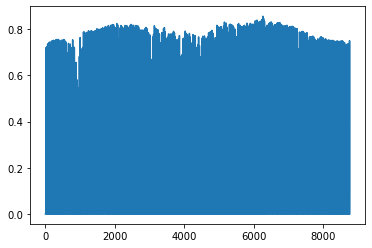

In [17]:
data_pv.plot()

<AxesSubplot:xlabel='snapshot', ylabel='Leistung in GW'>

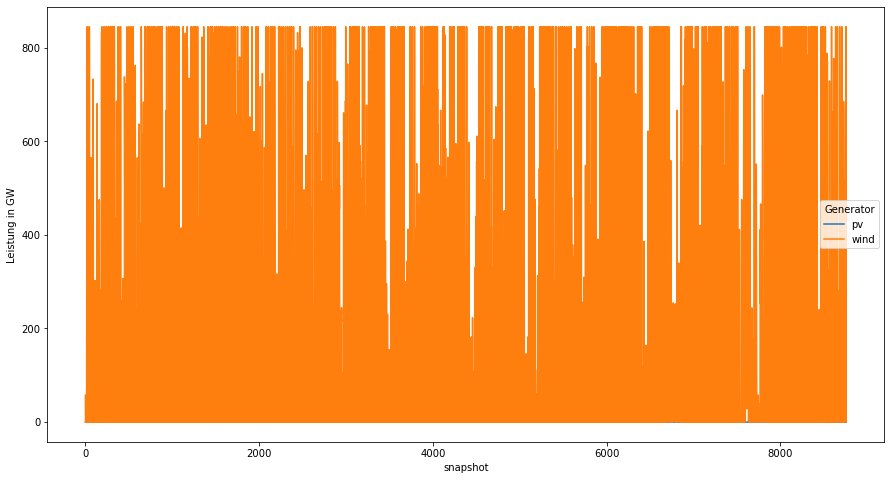

In [18]:
(network.generators_t.p/1000).plot(figsize = (15,8), ylabel = 'Leistung in GW')

In [19]:
network.generators_t.p['pv'][2400:2424]

snapshot
2400    0.000000
2401    0.000000
2402    0.000000
2403    0.000000
2404    0.000000
2405    0.000000
2406    0.000000
2407    0.000000
2408    0.000000
2409    0.000000
2410    0.000000
2411    0.065122
2412    0.266842
2413    0.455647
2414    0.580951
2415    0.661134
2416    0.692913
2417    0.679642
2418    0.627517
2419    0.526791
2420    0.374737
2421    0.177417
2422    0.004526
2423    0.000000
Name: pv, dtype: float64

In [20]:
network.links_t.p0[2400:2424]

Link,PEMEL,Ferntransport_GH2
snapshot,,
2400,112455.359280,0.0
2401,22505.402997,0.0
2402,0.000000,0.0
2403,1091.371490,0.0
2404,0.000000,0.0
2405,0.000000,0.0
2406,9227.049869,0.0
2407,10064.870407,0.0
2408,8041.974767,0.0


In [21]:
network.links.p_nom_opt/1000

Link
PEMEL                845.101892
Ferntransport_GH2      0.000000
Name: p_nom_opt, dtype: float64

In [22]:
network.links.p_nom/1000

Link
PEMEL                   0.000000
Ferntransport_GH2    1887.254902
Name: p_nom, dtype: float64

<AxesSubplot:xlabel='snapshot', ylabel='Leistung in GW'>

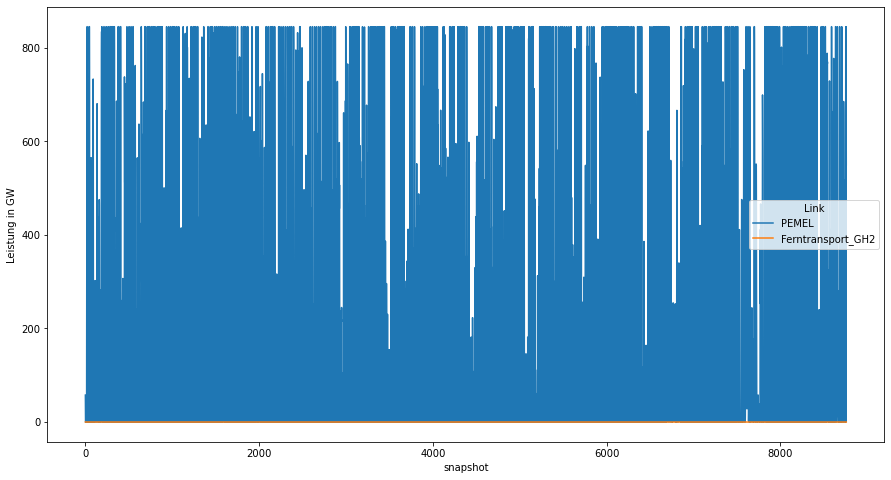

In [23]:
(network.links_t.p0/1000).plot(figsize = (15,8), ylabel = 'Leistung in GW')

<AxesSubplot:xlabel='snapshot', ylabel='Leistung in GW'>

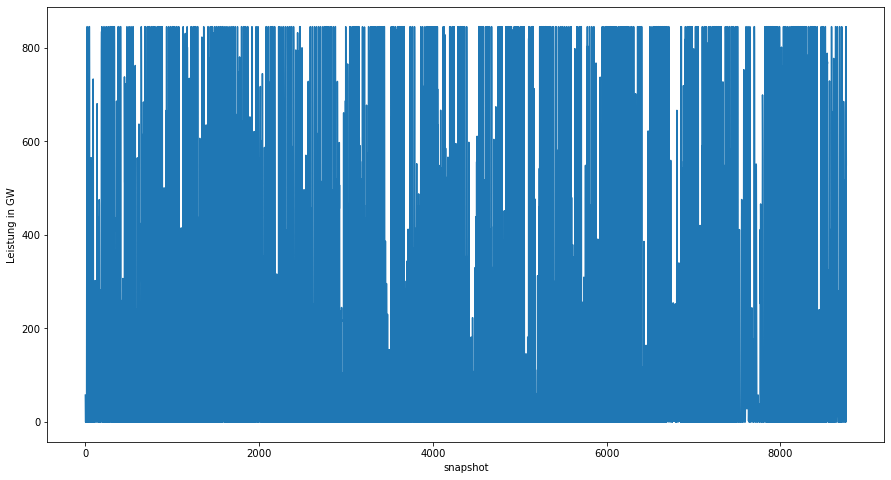

In [24]:
(network.links_t.p0['PEMEL']/1000).plot(figsize = (15,8), ylabel = 'Leistung in GW')

In [25]:
network.stores.e_nom_opt

Store
antofagasta_GH2       0.000000e+00
hydrogen_store_1.1    0.000000e+00
hydrogen_store_1.2    0.000000e+00
hydrogen_store_1.3    0.000000e+00
bremerhaven_GH2       1.012531e+07
cologne_GH2           0.000000e+00
Name: e_nom_opt, dtype: float64

<AxesSubplot:xlabel='snapshot'>

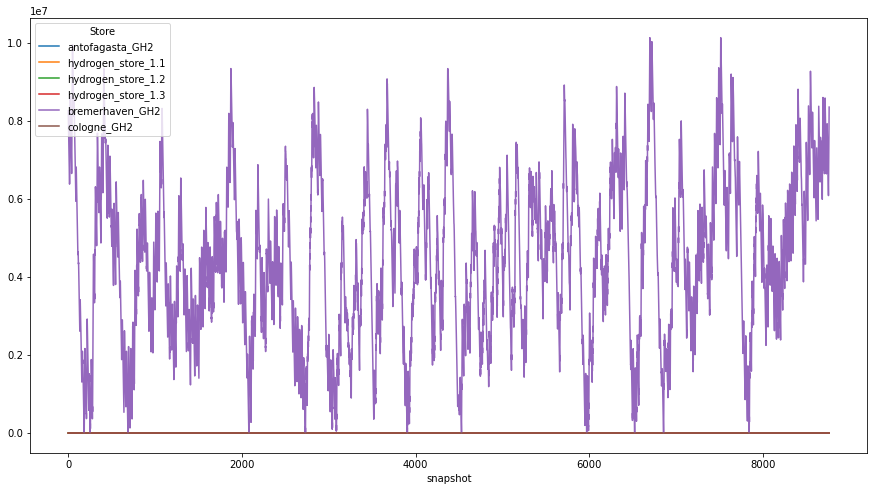

In [26]:
network.stores_t.e.plot(figsize = (15,8))

<AxesSubplot:xlabel='snapshot'>

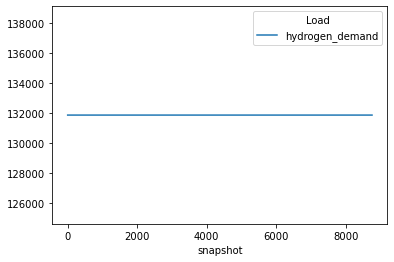

In [27]:
network.loads_t.p.plot()